In [2]:
import os
from dotenv import load_dotenv
from google.cloud import storage
import rasterio
from rasterio import windows
import os
import numpy as np

# Load environment variables from a .env file located in the same directory as this script
load_dotenv()

# Now you can access the environment variable
cloud_project = os.getenv("GOOGLE_CLOUD_PROJECT_NAME")
key_path = os.getenv("GOOGLE_CLOUD_KEY_PATH")

# Initialize a Google Cloud Storage client
client = storage.Client()

# Your bucket name
bucket_name = "hotspotstoplight_floodmapping"

# Create a GCS Bucket object
bucket = client.get_bucket(bucket_name)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = key_path

# Directory where you want to save the tiles
output_dir = "costa_rica_temp_outputs"

# Create the directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Ensure GDAL is configured to work with GCS URLs
os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "YES"
os.environ["CPL_VSIL_CURL_ALLOWED_EXTENSIONS"] = "tif"

In [1]:
# min max values for each band:
-8.0 3767.0
1.0 63.0
1.0 24.0
1.0 128.0
91.0 943.0
-521.0 32767.0
1.0 32767.0
1.0 32767.0
-32768.0 32767.0
-62.0 50.0
1.0 113.0
1.0 359.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0

In [9]:
import os
import rasterio
import numpy as np

# Directory where the TIFF files are stored
output_dir = "costa_rica_temp_outputs"

# List all TIFF files in the directory
tiff_files = [f for f in os.listdir(output_dir) if f.endswith('.tif')]

# Initialize a list to store arrays from each TIFF file
arrays = []

# Read each TIFF file and append its array to the list
for tiff_file in tiff_files:
    tiff_path = os.path.join(output_dir, tiff_file)
    with rasterio.open(tiff_path) as src:
        # Read data from all bands
        array = src.read()
        # Append the array to the list
        arrays.append(array)

# Assuming all TIFF files have the same number of bands and dimensions,
# Determine the dimensions for preallocation based on the first array
if arrays:
    num_bands, height, width = arrays[0].shape
    num_files = len(arrays)
    # Preallocate a 4D array (num_files x num_bands x height x width)
    all_arrays = np.zeros((num_files, num_bands, height, width), dtype=arrays[0].dtype)

    # Fill the preallocated array
    for i, array in enumerate(arrays):
        all_arrays[i] = array
else:
    all_arrays = np.array([])  # No TIFF files or an empty directory

# all_arrays is now a 4D ndarray containing all your TIFF files' data


In [10]:
all_arrays.shape

(426, 16, 256, 256)

In [12]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Assuming all_arrays is your 4D ndarray from the previous step with dimensions (num_files, num_bands, height, width)
num_files, num_bands, height, width = all_arrays.shape

# Initialize an encoder
encoder = OneHotEncoder(sparse_output=False)

In [22]:
import numpy as np

# Separate band 7 into a "masks" array
masks = all_arrays[:, 6, :, :]  # Band 7 is at index 6 (0-based indexing)

# Separate band 2 and one-hot encode it
landcover_data = all_arrays[:, 1, :, :]  # Band 2 is at index 1
# Flatten landcover_data to fit the encoder's expected input shape and fit-transform
landcover_encoded = encoder.fit_transform(landcover_data.reshape(-1, 1))

# Number of classes after encoding
num_classes = landcover_encoded.shape[1]
# Reshape back to original with an additional dimension for classes
landcover_encoded_reshaped = landcover_encoded.reshape(num_files, height, width, num_classes)

# Transpose the axes of the one-hot encoded bands to match the original image bands
landcover_encoded_transposed = np.transpose(landcover_encoded_reshaped, (0, 3, 1, 2))

# Prepare "images" array with all bands except band 2 and band 7
# Filtering bands to exclude band 2 (index 1) and band 7 (index 6), and drop bands with all NaN values
images = np.concatenate([all_arrays[:, :1, :, :], all_arrays[:, 2:6, :, :], all_arrays[:, 7:, :, :]], axis=1)
# Drop bands with all NaN values across all images
images = images[:, ~np.all(np.isnan(images), axis=(0, 2, 3)), :, :]

# Now, the shape of landcover_encoded_transposed should be (num_files, num_classes, height, width)
# which can be concatenated with the original image bands

# Add the one-hot encoded band 2 data back to "images"
images = np.concatenate([images, landcover_encoded_transposed], axis=1)

print(images.shape)

(426, 24, 256, 256)


In [24]:
import numpy as np

def drop_all_nan_bands(data):
    """
    Drops bands that contain all NaN values from a 4D NumPy array.

    Parameters:
    - data: A 4D NumPy array of shape (samples, bands, height, width).

    Returns:
    - A 4D NumPy array with bands containing all NaN values removed.
    """
    # Check for NaNs across the height and width dimensions for each band
    # This will result in a boolean array where True indicates a band is all NaN
    is_nan_band = np.all(np.isnan(data), axis=(2, 3))

    # Use the boolean array to select bands that are not all NaN
    filtered_data = data[:, ~np.all(is_nan_band, axis=0), :, :]

    return filtered_data

In [25]:
filt_image = drop_all_nan_bands(images)

In [26]:
filt_image.shape

(426, 24, 256, 256)

In [36]:
# return the min and max values for each band, omitting NaN values
def min_max_values(data):
    """
    Returns the minimum and maximum values for each band in a 4D NumPy array,
    omitting NaN values.

    Parameters:
    - data: A 4D NumPy array of shape (samples, bands, height, width).

    Returns:
    - A tuple containing two NumPy arrays:
      - The minimum values for each band.
      - The maximum values for each band.
    """
    # Compute the minimum and maximum values for each band, ignoring NaNs
    min_values = np.nanmin(data, axis=(0, 2, 3))
    max_values = np.nanmax(data, axis=(0, 2, 3))

    return min_values, max_values

def min_max_scale(data, min_values, max_values):
    """
    Perform min-max scaling on a 4D NumPy array.

    Parameters:
    - data: A 4D NumPy array of shape (samples, bands, height, width).
    - min_values: A NumPy array containing the minimum values for each band.
    - max_values: A NumPy array containing the maximum values for each band.

    Returns:
    - A scaled version of the input data using min-max scaling.
    """
    # Ensure that min_values and max_values have compatible shapes for broadcasting
    min_values = min_values.reshape(1, -1, 1, 1)
    max_values = max_values.reshape(1, -1, 1, 1)

    # Scale the data using min-max scaling
    # Avoid division by zero and handle NaN values
    with np.errstate(divide='ignore', invalid='ignore'):
        scaled_data = np.where(max_values != min_values, (data - min_values) / (max_values - min_values), np.nan)

    return scaled_data


In [37]:
# Get the min and max values for each band across all images
min_values, max_values = min_max_values(images)

# Drop bands that contain all NaN values
filt_image = drop_all_nan_bands(images)

# Perform min-max scaling across all images
scaled_data = min_max_scale(filt_image, min_values, max_values)

# Verify the shape of the scaled data
print("Scaled data shape:", scaled_data.shape)

Scaled data shape: (426, 24, 256, 256)


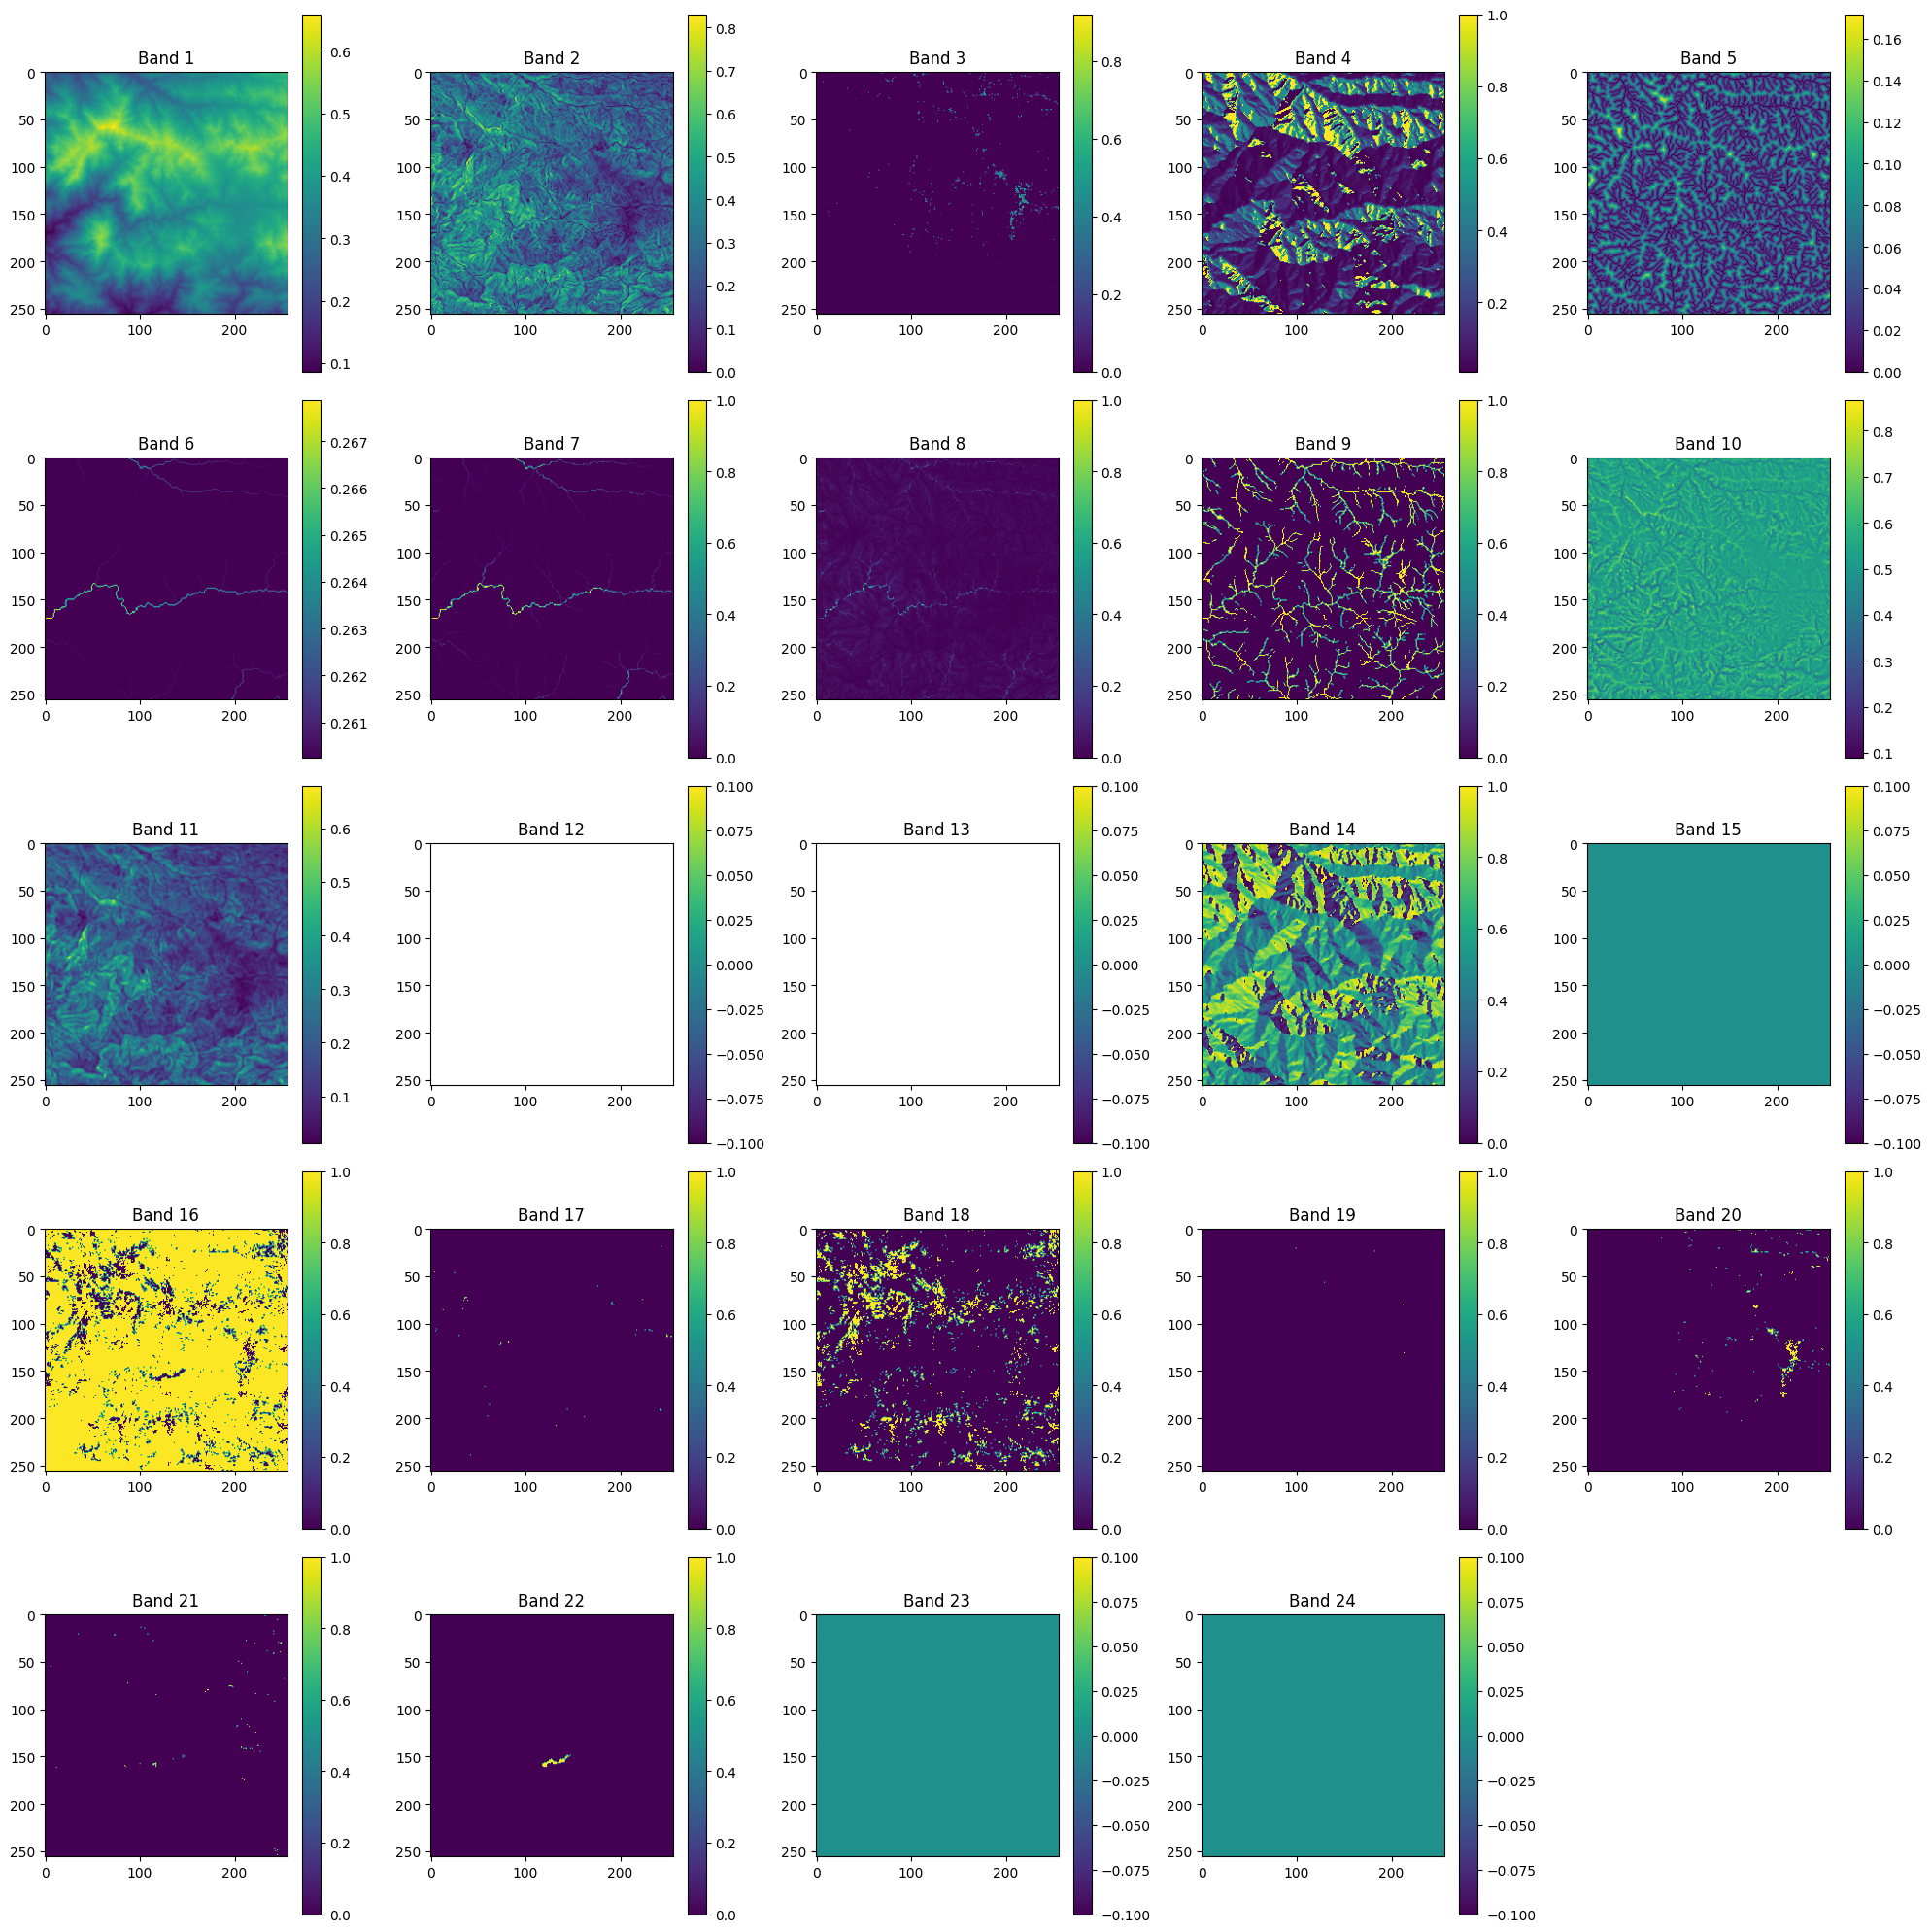

In [41]:
import matplotlib.pyplot as plt

# Assuming the shape of scaled_data is (samples, bands, height, width)
bands = scaled_data.shape[1]  # Number of bands in each image

# Calculate grid size for plots
n_cols = int(np.ceil(np.sqrt(bands)))  # Number of columns
n_rows = int(np.ceil(bands / n_cols))  # Number of rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

# Plot bands from the first image
first_image = scaled_data[100]  # Select the first image
for i in range(bands):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    im = ax.imshow(first_image[i], cmap='viridis')  # Plot each band
    ax.set_title(f'Band {i+1}')
    fig.colorbar(im, ax=ax)

# If the number of subplots is not a perfect square, some subplots might be empty and can be turned off.
for i in range(bands, n_rows * n_cols):
    axes.flat[i].axis('off')

plt.tight_layout()
plt.show()

In [42]:
# create a dataloader to load the data into a pytorch model. the data are stored in a 4D numpy array with dimensions (samples, bands, height, width)
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor:
    def __call__(self, sample):
        return torch.from_numpy(sample).float()
    
# Assuming scaled_data is your 4D NumPy array with dimensions (samples, bands, height, width)
# Create a custom dataset
dataset = CustomDataset(scaled_data, transform=ToTensor())

# Create a DataLoader
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self, in_channels):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 1, kernel_size=3, padding=1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = self.sigmoid(self.conv3(x))  # Sigmoid activation to output probabilities
        return x

In [44]:
model = SimpleCNN(in_channels=24) 
optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.BCELoss()

In [45]:
num_epochs = 10

model.train()  # Set the model to training mode

for epoch in range(num_epochs):  # Define `num_epochs` according to your needs
    for batch in dataloader:
        images = batch[0]  # Assuming your dataset returns a tuple (features, labels)
        masks = batch[1].float()  # Ensure masks are float for BCELoss

        # Forward pass
        predictions = model(images)
        predictions = predictions.squeeze(1)  # Remove channel dim, if necessary

        print("Prediction min:", predictions.min().item(), "max:", predictions.max().item())
        print("Mask min:", masks.min().item(), "max:", masks.max().item())

        valid_preds = torch.isfinite(predictions)
        if valid_preds.all():
            loss = loss_fn(predictions, masks)
        else:
            print("Invalid predictions detected")
            continue  # Skip this batch or handle the situation as needed


        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        for name, param in model.named_parameters():
            if param.grad is not None and torch.isnan(param.grad).any():
                print(f"NaN gradient in {name}")

        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Prediction min: nan max: nan
Mask min: nan max: nan
Invalid predictions detected
Prediction min: nan max: nan
Mask min: nan max: nan
Invalid predictions detected
Prediction min: nan max: nan
Mask min: nan max: nan
Invalid predictions detected
Prediction min: nan max: nan
Mask min: nan max: nan
Invalid predictions detected
Prediction min: nan max: nan
Mask min: nan max: nan
Invalid predictions detected
Prediction min: nan max: nan
Mask min: nan max: nan
Invalid predictions detected
Prediction min: nan max: nan
Mask min: nan max: nan
Invalid predictions detected
Prediction min: nan max: nan
Mask min: nan max: nan
Invalid predictions detected
Prediction min: nan max: nan
Mask min: nan max: nan
Invalid predictions detected
Prediction min: nan max: nan
Mask min: nan max: nan
Invalid predictions detected
Prediction min: nan max: nan
Mask min: nan max: nan
Invalid predictions detected
Prediction min: nan max: nan
Mask min: nan max: nan
Invalid predictions detected
Prediction min: nan max: nan

NameError: name 'loss' is not defined